# Modeling

<center>Which zone will the hurricane producing storm hit?</center>

![alt text](./images/USA_zones.png)
<center>(Figure 1) Impact Zones</center>

Import modules

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from imblearn.over_sampling import RandomOverSampler
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.optimizers import Adam
from keras.models import model_from_json
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import seaborn as sns

/home/raven/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Loading data

In [2]:
def load_data():
    # Returns dataframe of preprocessed hurricane data
    df = pd.read_csv('./data/hurdat2_preprocessed.csv')
    df.drop('Unnamed: 0', axis=1, inplace=True)
    return df

Calculating independent and dependent variables

In [3]:
cols = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K']
def Xy(df):
    # Return independent and dependent variables
    X = df.drop(cols, axis=1)
    y = df[cols]
    return(X, y)

Train test split

In [4]:
def ttsplit(X, y):
    # Returns training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.2,
                                                        random_state=13,
                                                        shuffle=True,
                                                        stratify=y)
    return(X_train, X_test, y_train, y_test)

Oversampling the minority class

In [5]:
def resample(X, y):
    # Returns X and y with oversampled minority class
    ros = RandomOverSampler(random_state=13)
    X_resampled, y_resampled = ros.fit_sample(X, y)    
    return(X_resampled, y_resampled)

Separating Hurricanes Irma and Harvey data for later model evaluation

In [6]:
df = load_data()
df.iloc[37265:].A = df.iloc[37265:].A.apply(lambda x: 0)
df.iloc[37265:].B = df.iloc[37265:].B.apply(lambda x: 0)
irma_harvey_jose = df.iloc[37161:]
df = df.iloc[:37161]

/home/raven/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


Initializing dictionaries

In [7]:
Xtrain = {}
Xtest = {}
ytrain = {}
ytest = {}
baseline = {}

Calculating training and test data sets

In [8]:
for zone in 'ABCDEFGHIJK':
    print('Preparing Zone {} data ...'.format(zone))
    df = load_data()
    X, y = Xy(df)
    print(len(y), sum(y.A))
#     X_train, X_test, y_train, y_test = ttsplit(X, y)
    X_train, X_test = X.iloc[:30000], X.iloc[30000:]
    y_train, y_test = y.iloc[:30000], y.iloc[30000:]
    X_train_resampled, y_train_resampled = resample(X_train, y_train[zone])
    print(len(y_train_resampled), sum(y_train_resampled))
    ss = StandardScaler()
    X_train_resampled_ss = ss.fit_transform(X_train_resampled)
    X_test_ss = ss.transform(X_test)
    Xtrain[zone] = X_train_resampled_ss
    Xtest[zone] = X_test_ss
    ytrain[zone] = y_train_resampled
    ytest[zone] = y_test[zone]
    baseline[zone] = 1 - y[zone].sum() / y[zone].count()

Preparing Zone A data ...
37324 1253
57934 28967
Preparing Zone B data ...
37324 1253
56134 28067
Preparing Zone C data ...
37324 1253
55530 27765
Preparing Zone D data ...
37324 1253
55056 27528
Preparing Zone E data ...
37324 1253
51642 25821
Preparing Zone F data ...
37324 1253
54178 27089
Preparing Zone G data ...
37324 1253
53674 26837
Preparing Zone H data ...
37324 1253
50978 25489
Preparing Zone I data ...
37324 1253
49774 24887
Preparing Zone J data ...
37324 1253
52306 26153
Preparing Zone K data ...
37324 1253
54326 27163


What is the baseline for each zone?

In [64]:
for zone in 'ABCDEFGHIJK':
    print(round(baseline[zone], 2))

0.97
0.93
0.93
0.92
0.87
0.91
0.9
0.86
0.83
0.87
0.91


Initialize neural network

In [10]:
def begin_neural_net(n_inputs):
    # Returns initialized keras object
    model = Sequential()
    hidden_units = n_inputs
    return model

Define neural network's topology

In [11]:
def topology(model, n_inputs):
    # Returns keras object
    model.add(Dense(n_inputs,
                    input_dim=n_inputs,
                    activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(n_inputs + 30,
                    activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(12,
                    activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

Saving model and weights

In [12]:
def save_model(model, zone):
    # Saves neural net and weights
    # https://machinelearningmastery.com/save-load-keras-deep-learning-models/
    model_json = model.to_json()
    with open('./models/' + zone + '.json', 'w') as json_file:
        json_file.write(model_json)
    model.save_weights('./models/' + zone + '.h5')

Generates graph of model's loss function value

In [13]:
def plot_loss(hist, zone):
    # Returns plot of loss function vs epochs
    plt.figure(figsize=(10, 6))
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Zone {} loss'.format(zone))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='best') ## I love this loc = 'best' command.
    plt.show()    

Generates graph of model's accuracy 

In [14]:
def plot_acc(hist, zone):
    # Returns plot of accuracy vs epochs
    plt.figure(figsize=(10, 6))
    plt.plot(hist.history['acc'])
    plt.plot(hist.history['val_acc'])
    plt.title('Zone {} accuracy'.format(zone))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='best')
    plt.show()
    hist.history['val_acc'][-1]

Plotting style

In [15]:
custom_style = {'axes.axisbelow': True,
                'axes.edgecolor': 'white',
                'axes.facecolor': '#3C4053',
                'axes.facecolor':'#3C4053',
                'figure.facecolor':'#3C4053',
                'axes.grid': True,
                'axes.labelcolor': 'grey',
                'axes.linewidth': 0,
                'grid.color': 'grey',
                'grid.linestyle': '-',
                'image.cmap': 'Greys',
                'legend.frameon': False,
                'legend.numpoints': 1,
                'legend.scatterpoints': 1,
                'lines.solid_capstyle': 'round',
                'pdf.fonttype': 42,
                'text.color': 'white',
                'xtick.color': 'white',
                'xtick.direction': 'out',
                'xtick.major.size': 0,
                'xtick.minor.size': 0,
                'ytick.color': 'white',
                'ytick.direction': 'out',
                'ytick.major.size': 0,
                'ytick.minor.size': 0}
sns.set(font_scale=1.7, style='darkgrid', rc=custom_style)

Training neural networks for each zone

Train on 57934 samples, validate on 7324 samples
Epoch 1/1
57934/57934 [==============================] - 104s 2ms/step - loss: 0.0630 - acc: 0.9791 - val_loss: 0.4107 - val_acc: 0.9582


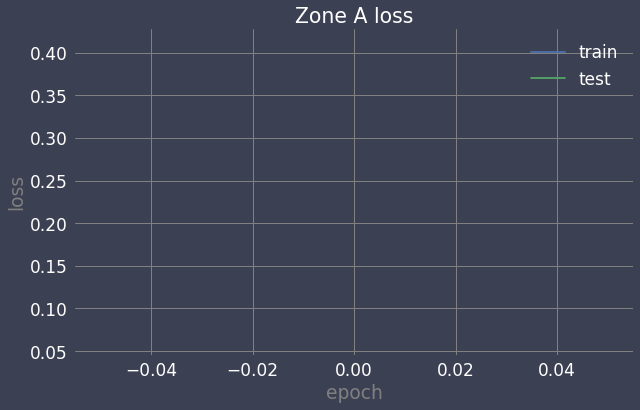

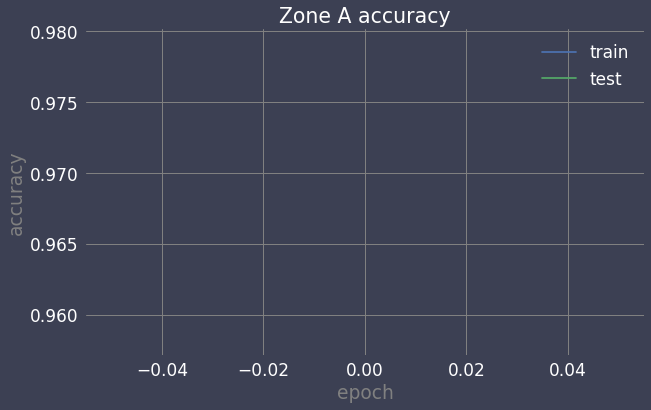

Zone A F1 score: 0.03164556962025317
Zone A accuracy: 0.958219552157291
[[7013   91]
 [ 215    5]]
*** Zone A ***
     Actual  Predicted
0         0          0
1         0          0
2         0          0
3         0          0
4         0          0
5         0          0
6         0          0
7         0          0
8         0          0
9         0          0
10        0          0
11        0          0
12        0          0
13        0          0
14        0          0
15        0          0
16        0          0
17        0          0
18        0          0
19        0          0
20        0          0
21        0          0
22        0          0
23        0          0
24        0          0
25        0          1
26        0          1
27        0          1
28        0          1
29        0          1
30        0          1
31        0          1
32        0          1
33        0          1
34        0          1
35        0          1
36        0          1
37        0 

KeyboardInterrupt: 

In [249]:
neural_net = {}
F1_scores = {}
irma_harvey_jose_preds = {}
for zone in 'ABCDEFGHIJK':
    # Initialize model
    n_inputs = Xtrain[zone].shape[1]
    model = begin_neural_net(n_inputs)
    model = topology(model, n_inputs)
    # Compile
    model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
    # Train model
    hist = model.fit(Xtrain[zone],
                     ytrain[zone],
                     validation_data=(Xtest[zone], ytest[zone]),
                     epochs=1,
                     batch_size=4,
                     shuffle=True,
                     verbose=1)
    # Saving results
    save_model(model, zone)
    neural_net[zone] = model
    # Ploting results
    plot_loss(hist, zone)
    plot_acc(hist, zone)
    # F1 score on test set
    F1_scores[zone] = metrics.f1_score(ytest[zone], np.round(model.predict(Xtest[zone])))
    print('Zone {} F1 score: {}'.format(zone, F1_scores[zone]))
    print('Zone {} accuracy: {}'.format(zone, metrics.accuracy_score( ytest[zone],np.round(model.predict(Xtest[zone])))))
    print(metrics.confusion_matrix(ytest[zone], np.round(model.predict(Xtest[zone]))))
    # Predictions for Hurricanes Irma and Harvey
    irma_harvey_jose_X = ss.transform(irma_harvey_jose.drop(cols, axis=1))
    irma_harvey_jose_preds[zone] = np.ravel(model.predict_classes(irma_harvey_jose_X))
    # Printing predictions
    print('*** Zone {} ***'.format(zone))
    print(pd.DataFrame(list(zip(irma_harvey_jose[zone],
                                irma_harvey_jose_preds[zone])),
          columns=['Actual', 'Predicted']))
    print('')

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV

In [250]:
clf = {}
for zone in 'ABCDEFGHIJK':
    clf[zone] = RandomForestClassifier()
    print('*** Zone {} ***'.format(zone))
    clf[zone].fit(Xtrain[zone], ytrain[zone])
    print('Test F1: ', metrics.f1_score(ytest[zone], clf[zone].predict(Xtest[zone])))
    print('Test acc: ', metrics.accuracy_score(ytest[zone], clf[zone].predict(Xtest[zone])))

*** Zone A ***
Cross validated F1:  0.993957747329925
Test F1:  0.27796610169491526
Test F1:  0.9709175314036046
*** Zone B ***
Cross validated F1:  0.9895041702024656
Test F1:  0.44999999999999996
Test F1:  0.9429273620972146
*** Zone C ***
Cross validated F1:  0.985916795680138
Test F1:  0.45033112582781465
Test F1:  0.9433369743309666
*** Zone D ***
Cross validated F1:  0.9813874075499008
Test F1:  0.4222539229671897
Test F1:  0.9447023484434736
*** Zone E ***
Cross validated F1:  0.9660108875078723
Test F1:  0.5397070161912105
Test F1:  0.9184871654833424
*** Zone F ***
Cross validated F1:  0.9778164472805294
Test F1:  0.3883211678832117
Test F1:  0.942790824685964
*** Zone G ***
Cross validated F1:  0.9772750509252444
Test F1:  0.3127463863337714
Test F1:  0.928590933915893
*** Zone H ***
Cross validated F1:  0.9655771968867894
Test F1:  0.5046296296296297
Test F1:  0.9123429819770618
*** Zone I ***
Cross validated F1:  0.9538433789833105
Test F1:  0.5080558539205156
Test F1:  0.8

In [251]:
clfada = {}
for zone in 'ABCDEFGHIJK':
    clfada[zone] = AdaBoostClassifier()
    print('*** Zone {} ***'.format(zone))
    clfada[zone].fit(Xtrain[zone], ytrain[zone])
    print('Test F1: ', metrics.f1_score(ytest[zone], clfada[zone].predict(Xtest[zone])))
    print('Test acc: ', metrics.accuracy_score(ytest[zone], clfada[zone].predict(Xtest[zone])))

*** Zone A ***
Cross validated F1:  0.8828799084366743
Test F1:  0.3269230769230769
Test F1:  0.9426542872747132
*** Zone B ***
Cross validated F1:  0.8294763042444228
Test F1:  0.3502377179080824
Test F1:  0.8880393227744402
*** Zone C ***
Cross validated F1:  0.7985919115619409
Test F1:  0.39773531493276715
Test F1:  0.883806663025669
*** Zone D ***
Cross validated F1:  0.7828750101326745
Test F1:  0.3594164456233422
Test F1:  0.8681048607318406
*** Zone E ***
Cross validated F1:  0.7210070232810859
Test F1:  0.39889415481832546
Test F1:  0.792190060076461
*** Zone F ***
Cross validated F1:  0.7263217276782897
Test F1:  0.24269167126309985
Test F1:  0.8125341343528126
*** Zone G ***
Cross validated F1:  0.7239479803040431
Test F1:  0.31578947368421056
Test F1:  0.7994265428727472
*** Zone H ***
Cross validated F1:  0.7223052358387296
Test F1:  0.43410246382479467
Test F1:  0.8024303659202622
*** Zone I ***
Cross validated F1:  0.7066485986480766
Test F1:  0.5138396025550035
Test F1: 

In [17]:
clflr = {}
for zone in 'ABCDEFGHIJK':
    clflr[zone] = LogisticRegression()
    print('*** Zone {} ***'.format(zone))
    clflr[zone].fit(Xtrain[zone], ytrain[zone])
    print('Test F1: ', metrics.f1_score(ytest[zone], clflr[zone].predict(Xtest[zone])))
    print('Test acc: ', metrics.accuracy_score(ytest[zone], clflr[zone].predict(Xtest[zone])))

*** Zone A ***
Test F1:  0.18566775244299674
Test acc:  0.9317312943746586
*** Zone B ***
Test F1:  0.2538593481989708
Test acc:  0.881212452211906
*** Zone C ***
Test F1:  0.2964453386988598
Test acc:  0.8567722555980338
*** Zone D ***
Test F1:  0.20408163265306123
Test acc:  0.8402512288367012
*** Zone E ***
Test F1:  0.3061377245508982
Test acc:  0.7468596395412342
*** Zone F ***
Test F1:  0.1541115583668775
Test acc:  0.7991534680502458
*** Zone G ***
Test F1:  0.25293489861259333
Test acc:  0.8088476242490442
*** Zone H ***
Test F1:  0.3421985815602837
Test acc:  0.7973784817039868
*** Zone I ***
Test F1:  0.35657620041753657
Test acc:  0.789595849262698
*** Zone J ***
Test F1:  0.2755438365194463
Test acc:  0.8499453850354998
*** Zone K ***
Test F1:  0.20539419087136931
Test acc:  0.895412342981977


In [ ]:
clfknn = {}
for zone in 'ABCDEFGHIJK':
    clfknn[zone] = KNeighborsClassifier()
    print('*** Zone {} ***'.format(zone))
    clfknn[zone].fit(Xtrain[zone], ytrain[zone])
    print('Test F1: ', metrics.f1_score(ytest[zone], clfknn[zone].predict(Xtest[zone])))
    print('Test acc: ', metrics.accuracy_score(ytest[zone], clfknn[zone].predict(Xtest[zone])))

*** Zone A ***
Test F1:  0.06623931623931624
Test acc:  0.7613326051338066
*** Zone B ***
Test F1:  0.1766933108960875
Test acc:  0.732796286182414
*** Zone C ***


In [ ]:
clfsvm = {}
for zone in 'A':
    for k in ['rbf', 'poly', 'sigmoid', 'linear']:
        clfsvm[zone] = SVC(kernel=k)
        print('*** Zone {} ***'.format(zone))
        clfsvm[zone].fit(Xtrain[zone], ytrain[zone])
        print('Test F1: ', metrics.f1_score(ytest[zone], clfsvm[zone].predict(Xtest[zone])))
        print('Test acc: ', metrics.accuracy_score(ytest[zone], clfsvm[zone].predict(Xtest[zone])))

*** Zone A ***
Test F1:  0.14457831325301204
Test acc:  0.9127525942108138
*** Zone A ***
Test F1:  0.14599574769666904
Test acc:  0.8354724194429274
*** Zone A ***
Test F1:  0.20373250388802489
Test acc:  0.860185690879301
*** Zone A ***


In [62]:
clf = {}
for zone in 'ABCDEFGHIJK':
    f1s = []
    accs= []
    for _ in range(20):
        rf = RandomForestClassifier(n_estimators=13, n_jobs=-1)
        clf[zone] = rf
        rf.fit(Xtrain[zone], ytrain[zone])
        f1s.append(metrics.f1_score(ytest[zone], rf.predict(Xtest[zone])))
        accs.append(metrics.accuracy_score(ytest[zone], rf.predict(Xtest[zone])))
    print('Zone {}, Test F1: {} +/- {}'.format(zone, round(np.mean(f1s), 2),
                                               round(np.std(f1s)*2, 3)))
    print('Zone {}, Test acc: {} +/- {}'.format(zone, round(np.mean(accs), 2),
                                               round(np.std(accs)*2, 3)))

Zone A, Test F1: 0.35 +/- 0.055
Zone A, Test acc: 0.97 +/- 0.002
Zone B, Test F1: 0.47 +/- 0.017
Zone B, Test acc: 0.94 +/- 0.002
Zone C, Test F1: 0.47 +/- 0.021
Zone C, Test acc: 0.94 +/- 0.002
Zone D, Test F1: 0.44 +/- 0.035
Zone D, Test acc: 0.94 +/- 0.003
Zone E, Test F1: 0.53 +/- 0.024
Zone E, Test acc: 0.91 +/- 0.006
Zone F, Test F1: 0.41 +/- 0.035
Zone F, Test acc: 0.94 +/- 0.005
Zone G, Test F1: 0.33 +/- 0.034
Zone G, Test acc: 0.93 +/- 0.005
Zone H, Test F1: 0.52 +/- 0.023
Zone H, Test acc: 0.91 +/- 0.004
Zone I, Test F1: 0.55 +/- 0.019
Zone I, Test acc: 0.88 +/- 0.005
Zone J, Test F1: 0.4 +/- 0.027
Zone J, Test acc: 0.9 +/- 0.006
Zone K, Test F1: 0.33 +/- 0.025
Zone K, Test acc: 0.94 +/- 0.003


In [67]:
irma_harvey_jose_preds = {}
for zone in 'ABCDEFGHIJK':
    rf = RandomForestClassifier(n_estimators=13, n_jobs=-1)
    rf.fit(Xtrain[zone], ytrain[zone])
    irma_harvey_jose_X = ss.transform(irma_harvey_jose.drop(cols, axis=1))
    irma_harvey_jose_preds[zone] = list(rf.predict(irma_harvey_jose_X))
    print('*** Zone {} ***'.format(zone))
#     print(pd.DataFrame(list(zip(irma_harvey_jose[zone],
#                                 irma_harvey_jose_preds[zone])),

*** Zone A ***
*** Zone B ***
*** Zone C ***
*** Zone D ***
*** Zone E ***
*** Zone F ***
*** Zone G ***
*** Zone H ***
*** Zone I ***
*** Zone J ***
*** Zone K ***


In [93]:
pd.options.display.max_rows = 200
pd.DataFrame(irma_harvey_jose_preds).iloc[:15]

,A,B,C,D,E,F,G,H,I,J,K
0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0


In [94]:
pd.options.display.max_columns = 200
irma_harvey_jose.reset_index()

,index,lat,lon,max_wind,td,A,B,C,D,E,F,G,H,I,J,K,statusDB,statusEX,statusHU,statusLO,statusSD,statusSS,statusTD,statusTS,statusWV,lat1,lon1,max_wind1,td1,statusDB1,statusEX1,statusHU1,statusLO1,statusSD1,statusSS1,statusTD1,statusTS1,statusWV1,lat2,lon2,max_wind2,td2,statusDB2,statusEX2,statusHU2,statusLO2,statusSD2,statusSS2,statusTD2,statusTS2,statusWV2,lat3,lon3,max_wind3,td3,statusDB3,statusEX3,statusHU3,statusLO3,statusSD3,statusSS3,statusTD3,statusTS3,statusWV3,lat4,lon4,max_wind4,td4,statusDB4,statusEX4,statusHU4,statusLO4,statusSD4,statusSS4,statusTD4,statusTS4,statusWV4,lat5,lon5,max_wind5,td5,statusDB5,statusEX5,statusHU5,statusLO5,statusSD5,statusSS5,statusTD5,statusTS5,statusWV5,lat6,lon6,max_wind6,td6,statusDB6,statusEX6,statusHU6,statusLO6,statusSD6,statusSS6,...,year1985,year1986,year1987,year1988,year1989,year1990,year1991,year1992,year1993,year1994,year1995,year1996,year1997,year1998,year1999,year2000,year2001,year2002,year2003,year2004,year2005,year2006,year2007,year2008,year2009,year2010,year2011,year2012,year2013,year2014,year2015,year2016,year2017,month1,month2,month3,month4,month5,month6,month7,month8,month9,month10,month11,month12,day1,day2,day3,day4,day5,day6,day7,day8,day9,day10,day11,day12,day13,day14,day15,day16,day17,day18,day19,day20,day21,day22,day23,day24,day25,day26,day27,day28,day29,day30,day31,hour0,hour1,hour2,hour3,hour4,hour5,hour6,hour7,hour8,hour9,hour10,hour11,hour12,hour13,hour14,hour15,hour16,hour17,hour18,hour19,hour20,hour21,hour22,hour23
0,37161,17.1,-34.2,95,6.0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,16.7,-33.4,80.0,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,16.4,-32.5,65.0,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,-31.7,55.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,16.3,-30.8,50.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,16.3,-29.7,45.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,16.2,-28.3,35.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,37162,17.5,-35.1,100,6.0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,17.1,-34.2,95.0,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,16.7,-33.4,80.0,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,16.4,-32.5,65.0,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,-31.7,55.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,16.3,-30.8,50.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,16.3,-29.7,45.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,37163,17.9,-36.1,100,6.0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,17.5,-35.1,100.0,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,17.1,-34.2,95.0,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,16.7,-33.4,80.0,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,16.4,-32.5,65.0,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,-31.7,55.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,16.3,-30.8,50.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,37164,18.4,-37.3,100,6.0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,17.9,-36.1,100.0,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,17.5,-35.1,100.0,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,17.1,-34.2,95.0,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,16.7,-33.4,80.0,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,16.4,-32.5,65.0,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3,-31.7,55.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,37165,18.8,-38.5,100,6.0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,18.4,-37.3,100.0,6.0,0.0,0.0,1.0,0.0,0.0,0.0